In [13]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [10]:
%%time
_pwd = b'2019Deepfashion2**'
zipf = zipfile.ZipFile('train.zip')

CPU times: user 3 s, sys: 62.4 ms, total: 3.06 s
Wall time: 3.08 s


In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'folder', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=5)

383922


,index,root_path,folder,filename,path
275338,275341,train,image,070977.jpg,train/image/070977.jpg
300436,300439,train,image,092971.jpg,train/image/092971.jpg
312798,312801,train,image,182404.jpg,train/image/182404.jpg
20655,20657,train,annos,131904.json,train/annos/131904.json
57556,57558,train,annos,099997.json,train/annos/099997.json


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 10.89 GB


# Basic EDA


In [6]:
samples = df[df['folder']=='image']['path'].sample(10)

In [7]:
samples

240601    train/image/145544.jpg
231511    train/image/086011.jpg
195517    train/image/096996.jpg
382105    train/image/025378.jpg
369907    train/image/003179.jpg
357337    train/image/096725.jpg
265327    train/image/090374.jpg
213821    train/image/147773.jpg
232359    train/image/066867.jpg
249172    train/image/014813.jpg
Name: path, dtype: object

In [ ]:
samples = df[df['folder']=='image']['path'].sample(10)
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [67]:
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [69]:
#anno['item1'].keys()
#dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])

In [49]:
if False:
    segs = anno['item1']['segmentation'][0]
    segs_arr = np.array([str(x).split('.') for x in segs])

    marks = []
    for idx in range(0,len(anno['item1']['landmarks']),3):
        x = anno['item1']['landmarks'][idx]
        y = anno['item1']['landmarks'][idx+1]
        if not(x==0 & y==0):
            marks.append([x,y])
    marks_arr = np.array(marks)
    #marks_arr = marks_arr[marks_arr[:, 0].argsort()]

### Inspect a few sample images and corresponding bounding boxes

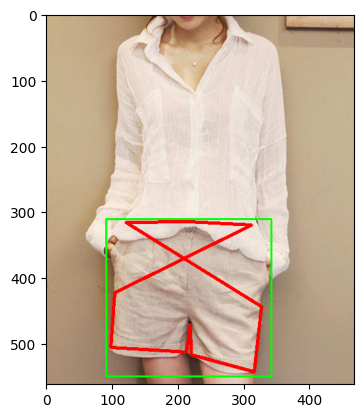

In [51]:
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(img)
    plt.show()

# Examine classes

In [184]:
%%time

ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = df[df['folder']=='annos']
print('# rows', len(annos))
for idx, row in tqdm(annos.iterrows()): 
    file = row.path
    anno = zipf.read(file, pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(row.filename.split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 191961


0it [00:00, ?it/s]

CPU times: user 2min 24s, sys: 3.74 s, total: 2min 28s
Wall time: 2min 30s


In [191]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

312186


,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
0,024410,user,3,1,2,1,"[211, 148, 2, 122, 90, 2, 152, 168, 2, 219, 18...","[2, 78, 452, 694]",1,5,vest
1,024334,shop,2,2,1,2,"[317, 114, 1, 242, 134, 2, 280, 170, 2, 363, 1...","[65, 57, 616, 589]",1,1,short sleeve top
2,024334,shop,3,2,1,1,"[391, 261, 1, 310, 288, 2, 347, 288, 2, 395, 2...","[176, 57, 721, 928]",2,13,sling dress
3,024330,user,3,2,2,2,"[271, 68, 1, 0, 0, 0, 187, 54, 2, 257, 109, 2,...","[2, 1, 465, 606]",1,1,short sleeve top
4,024330,user,3,2,2,1,"[226, 115, 1, 92, 63, 2, 169, 99, 2, 223, 124,...","[35, 0, 467, 623]",2,13,sling dress


In [192]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [193]:
df_meta = df_meta[(df_meta.source=='shop') & (df_meta.scale>1) & 
                  (df_meta.occlusion<2) & (df_meta.zoom<2) & 
                  (df_meta.viewpoint==2)]

In [194]:
cnts = df_meta.groupby('category_name').count()
cnts

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
long sleeve dress,1647,1647,1647,1647,1647,1647,1647,1647,1647,1647
long sleeve outwear,2960,2960,2960,2960,2960,2960,2960,2960,2960,2960
long sleeve top,5915,5915,5915,5915,5915,5915,5915,5915,5915,5915
short sleeve dress,3042,3042,3042,3042,3042,3042,3042,3042,3042,3042
short sleeve outwear,119,119,119,119,119,119,119,119,119,119
short sleeve top,10703,10703,10703,10703,10703,10703,10703,10703,10703,10703
shorts,3685,3685,3685,3685,3685,3685,3685,3685,3685,3685
skirt,2860,2860,2860,2860,2860,2860,2860,2860,2860,2860
sling,227,227,227,227,227,227,227,227,227,227


In [195]:
# to be comparable with the test on 16k DF1
cats = ['long sleeve top', 
        'short sleeve top', 
        'shorts', 
        'trousers']

In [196]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [197]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

3685

In [198]:
# to start training on DF2 to compare with DF1, we'll go with about 4k each
samples = subset.groupby('category_name').sample(n=min_cnt, random_state=314)
len(samples)

14740

In [199]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [200]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(samples, test_size=0.2)
print(len(train),len(val))

11792 2948


In [201]:
val = pd.merge(df, val, on='id')
val = val[val.folder=='image']
len(val)

2948

In [202]:
train = pd.merge(df, train, on='id')
train = train[train.folder=='image']
len(train)

11792

In [203]:
train.iloc[0]

index                                                       275115
root_path                                                    train
folder                                                       image
filename                                                017794.jpg
path                                        train/image/017794.jpg
id                                                          017794
source                                                        shop
scale                                                            3
viewpoint                                                        2
zoom                                                             1
occlusion                                                        1
landmarks        [230, 7, 1, 182, 5, 2, 200, 24, 2, 227, 41, 2,...
bbox                                              [3, 5, 400, 427]
style                                                            0
category_id                                                   

In [226]:
if not os.path.exists('df2'):
    os.mkdir('df2')

if not os.path.exists('df2/images'):
    os.mkdir('df2/images')
if not os.path.exists('df2/images/train'):
    os.mkdir('df2/images/train')
if not os.path.exists('df2/images/val'):
    os.mkdir('df2/images/val')

if not os.path.exists('df2/labels'):
    os.mkdir('df2/labels')
if not os.path.exists('df2/labels/train'):
    os.mkdir('df2/labels/train')
if not os.path.exists('df2/labels/val'):
    os.mkdir('df2/labels/val')

In [233]:
def createFiles(data=train, type_='train'):
    target_dim = 640.0
    for i, row in tqdm(data.iterrows()):
        filepath = row.path
        img = Image.open(io.BytesIO(zipf.read(filepath, pwd=_pwd)))
        w_orig = float(img.size[0])
        h_orig = float(img.size[1])
        img.thumbnail((target_dim, target_dim)) 
        if 'png' in str(type(img)).lower():
            img = img.convert('RGB')
        img.save('df2/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

        (x1, y1, x2, y2) = [float(b) for b in row.bbox]
        x = round((((x2 - x1)/2) + x1) / w_orig, 4)
        y = round((((y2 - y1)/2) + y1) / h_orig, 4)
        w = round((x2 - x1) / w_orig, 4)
        h = round((y2 - y1) / h_orig, 4)

        idx = cats.index(row.category_name)
        metadata = str(idx) + f' {x} {y} {w} {h}'
        fileroot = 'df2/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

        f = open(fileroot, 'w')
        f.write(metadata)
        f.close()

In [234]:
createFiles(train, type_='train')
createFiles(val, type_='val')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [207]:
lines = []
lines.append('path: ../datasets/df2 # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('df2/df2.yaml', 'w')
f.writelines(lines)
f.close()

# These lines used for debugging

In [223]:
bbox_ = df_meta_all[df_meta_all.id=='000908'].bbox
path_ = 'train/image/000908.jpg'
img = Image.open(io.BytesIO(zipf.read(path_, pwd=_pwd)))
(x1, y1, x2, y2) = bbox_
img = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
print(row.category_name)
plt.show()

AttributeError: 'Series' object has no attribute 'path'

In [212]:
row

index                                                       213175
root_path                                                    train
folder                                                       image
filename                                                027196.jpg
path                                        train/image/027196.jpg
id                                                          027196
source                                                        shop
scale                                                            2
viewpoint                                                        2
zoom                                                             1
occlusion                                                        1
landmarks        [412, 22, 1, 334, 32, 1, 347, 75, 2, 408, 80, ...
bbox                                           [153, 13, 654, 450]
style                                                            2
category_id                                                   

In [229]:
train[train.filename=='035148.jpg']

,index,root_path,folder,filename,path,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
1775,338250,train,image,035148.jpg,train/image/035148.jpg,035148,shop,2,2,1,1,"[247, 110, 1, 235, 107, 2, 239, 113, 2, 245, 1...","[155, 103, 297, 256]",1,2,long sleeve top


In [232]:
Image.open(io.BytesIO(zipf.read('train/image/035148.jpg', pwd=_pwd))).size



(496, 328)